In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns
import pydicom
import time
import gc
import operator 
from apex import amp 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline
from skimage.io import imread,imshow
from helper import *
from apex import amp
import helper
import torchvision.models as models
from torch.optim import Adam
from defenitions import *

/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
SEED = 22428429
#device=device_by_name("Tesla")
device=device_by_name("RTX")
#device = "cpu"

In [3]:
def get_submission(test_df,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [4]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df=train_df[~train_df.PatientID.isin(bad_images)].reset_index(drop=True)
train_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


In [5]:
test_df = pd.read_csv(data_dir+'test.csv')
test_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5,ebfd7e4506,cf1b6b11,93407cadbb,30,80,158.458000,-125.0,-135.598000
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5,6d95084e15,ad8ea58f,a337baa067,30,80,138.729050,-125.0,-101.797981
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5,8e06b2c9e0,ecfb278b,0cfe838d54,30,80,60.830002,-125.0,-133.300003
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5,e800f419cf,e96e31f4,c497ac5bad,30,80,55.388000,-125.0,-146.081000
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5,faeb7454f3,69affa42,854e4fbc01,30,80,33.516888,-125.0,-118.689819


In [6]:
split = train_df.SeriesI.unique()
np.random.seed(SEED)
np.random.shuffle(split)
split_train=split[:int(0.9*split.shape[0])]
split_val=split[int(0.9*split.shape[0]):]

idx_train = train_df[train_df.SeriesI.isin(set(split_train))].index.values
idx_validate = train_df[train_df.SeriesI.isin(set(split_val))].index.values
idx_train.shape
idx_validate.shape

(607272,)

(67232,)

In [7]:
def my_loss(y_pred,y_true,weights):
    return F.binary_cross_entropy_with_logits(y_pred,y_true,weights.repeat(y_pred.shape[0],1))

In [8]:
class parameter_scheduler():
    def __init__(self,model,do_first=['classifier'],num_epoch=1):
        self.model=model
        self.do_first = do_first
        self.num_epoch=num_epoch
    def __call__(self,epoch):
        if epoch>=self.num_epoch:
            for n,p in self.model.named_parameters():
                p.requires_grad=True
        else:
            for n,p in self.model.named_parameters():
                p.requires_grad= any(nd in n for nd in self.do_first)


In [9]:
def get_optimizer_parameters(model,klr):
    zero_layer=['conv0','norm0']
    param_optimizer = list(model.named_parameters())
    num_blocks=4
    no_decay=['bias']
    optimizer_grouped_parameters=[
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and any(nd in n for nd in zero_layer))], 'lr':klr*2e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and any(nd in n for nd in zero_layer)], 'lr':klr*2e-5, 'weight_decay': 0.0}
        ]
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
        ])
    for i in range(num_blocks):
        optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('denseblock{}'.format(i+1) in n))], 'lr':klr*(2.0**i)*2e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('denseblock{}'.format(i+1) in n)], 'lr':klr*(2.0**i)*2e-5, 'weight_decay': 0.0}
        ])
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('norm5' in n))], 'lr':klr*1e-4,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('norm5' in n)], 'lr':klr*1e-4, 'weight_decay': 0.0}
        ])
    return(optimizer_grouped_parameters)

    

/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


<IPython.core.display.Javascript object>


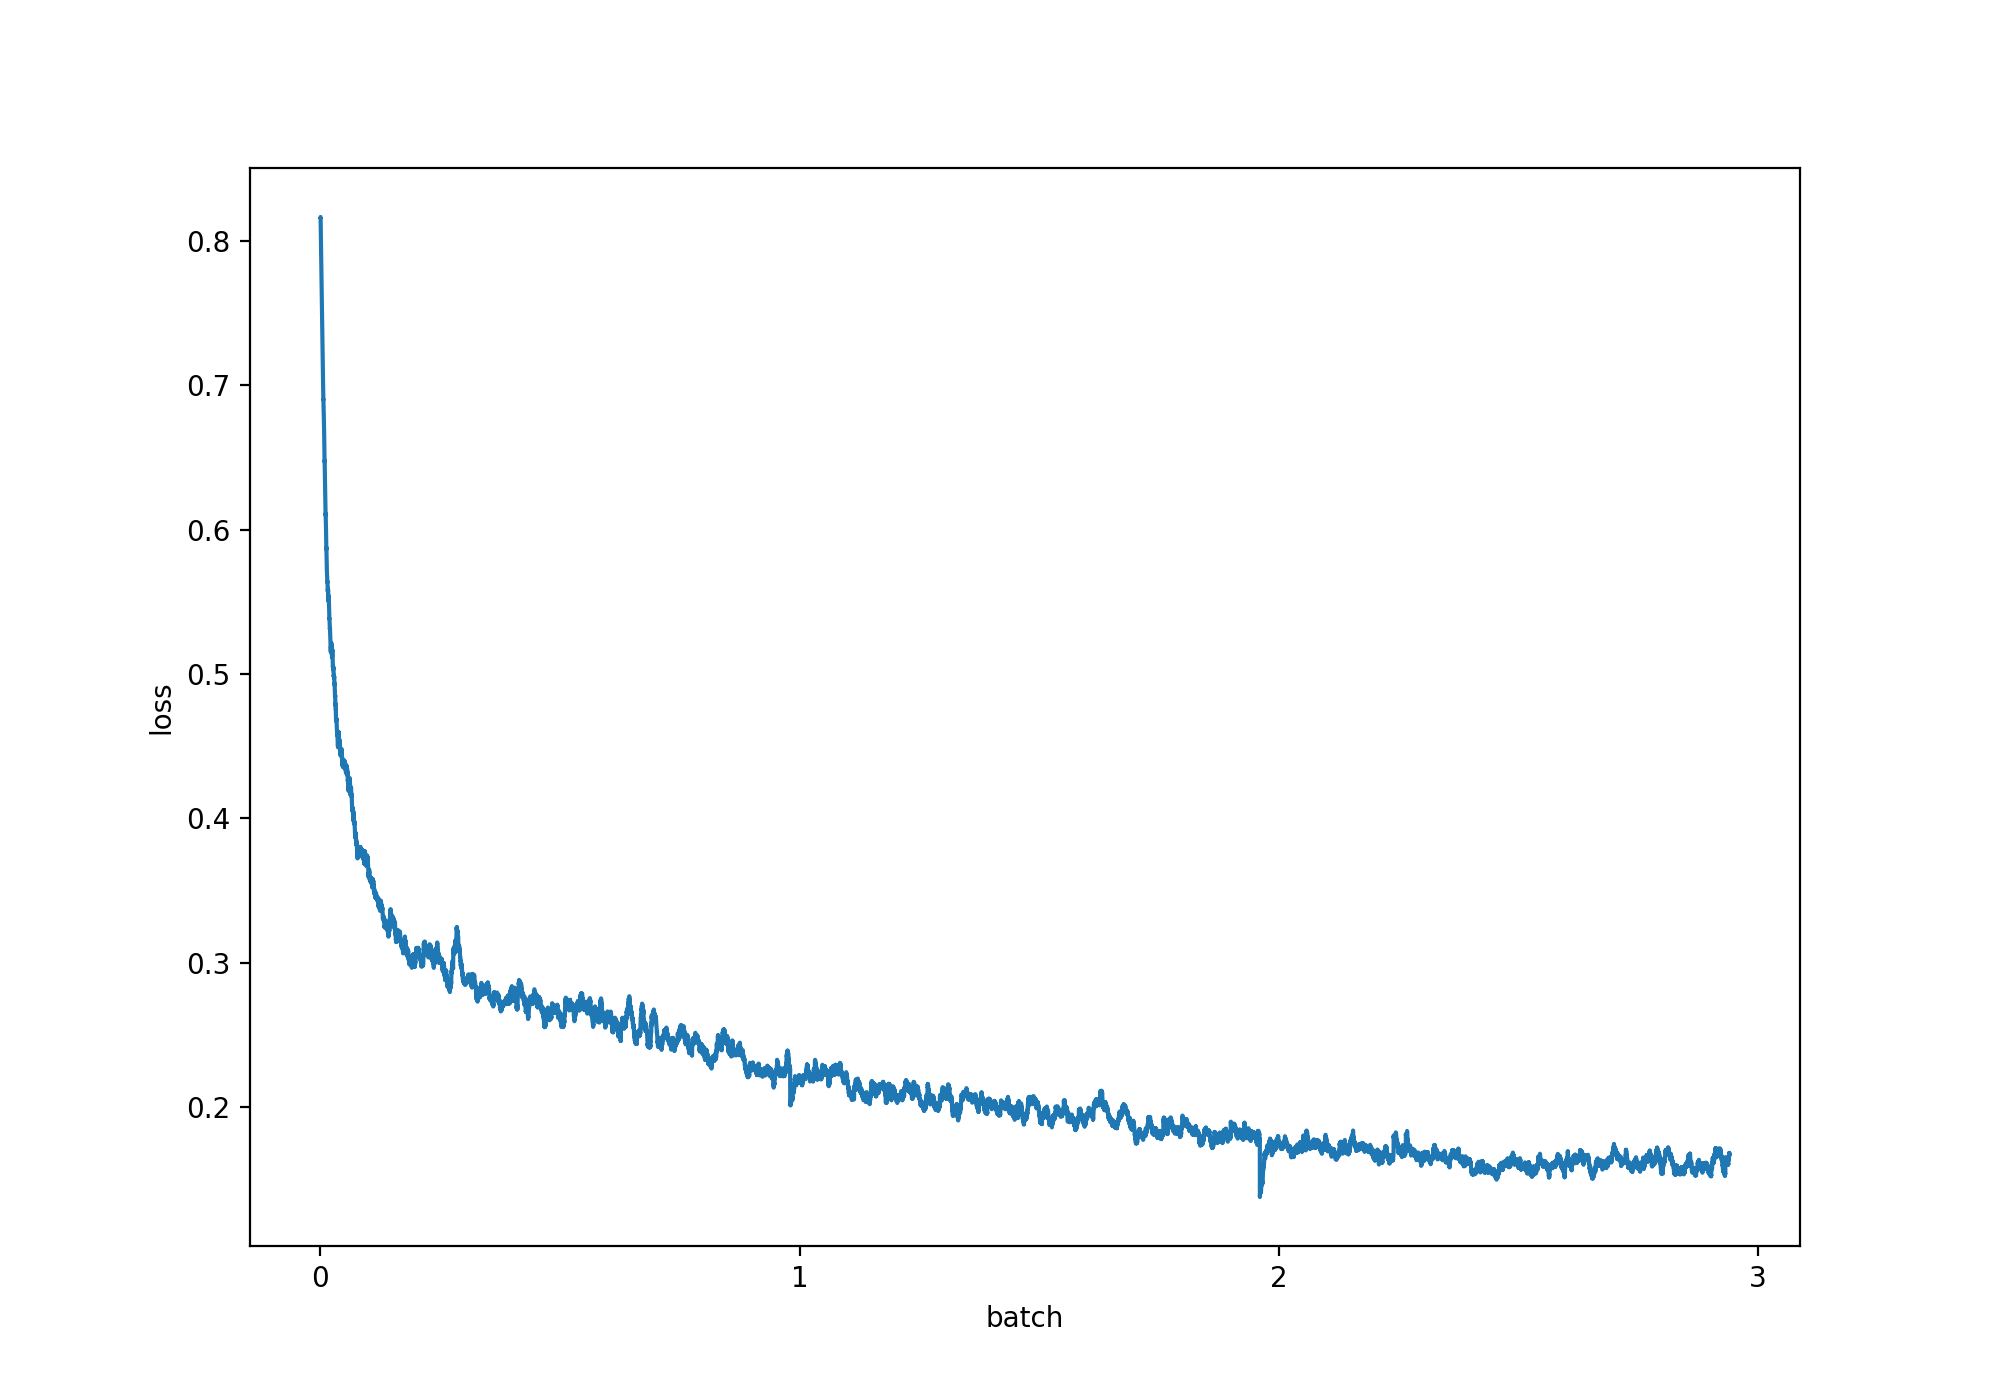

{'loss': 0.2254786538437836, 'val_loss': 0.0945222131611459}


{'loss': 0.17635327778768653, 'val_loss': 0.09492518389673982}


{'loss': 0.16738435428454998, 'val_loss': 0.09846866498870788}

0.0945222131611459


In [11]:
%matplotlib nbagg

num_split=2
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=24
num_workers=12
num_epochs=3
model_name,version = 'Densenet161_3' , 'basic'
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,
                           window_eq=3,equalize=True)
transform_val=MyTransform(out_size=512)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,
                               window_eq=3,equalize=True)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,int(num_train_optimization_steps/num_epochs)+1)
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//3,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=sampling,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

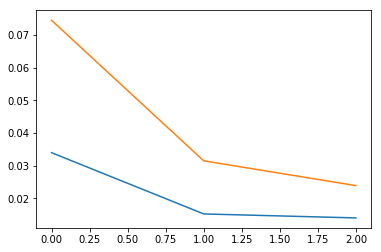

In [9]:
 plt.plot(np.array([[hist['val_loss'] for hist in history],[hist['loss'] for hist in history]]).transpose())

<IPython.core.display.Javascript object>


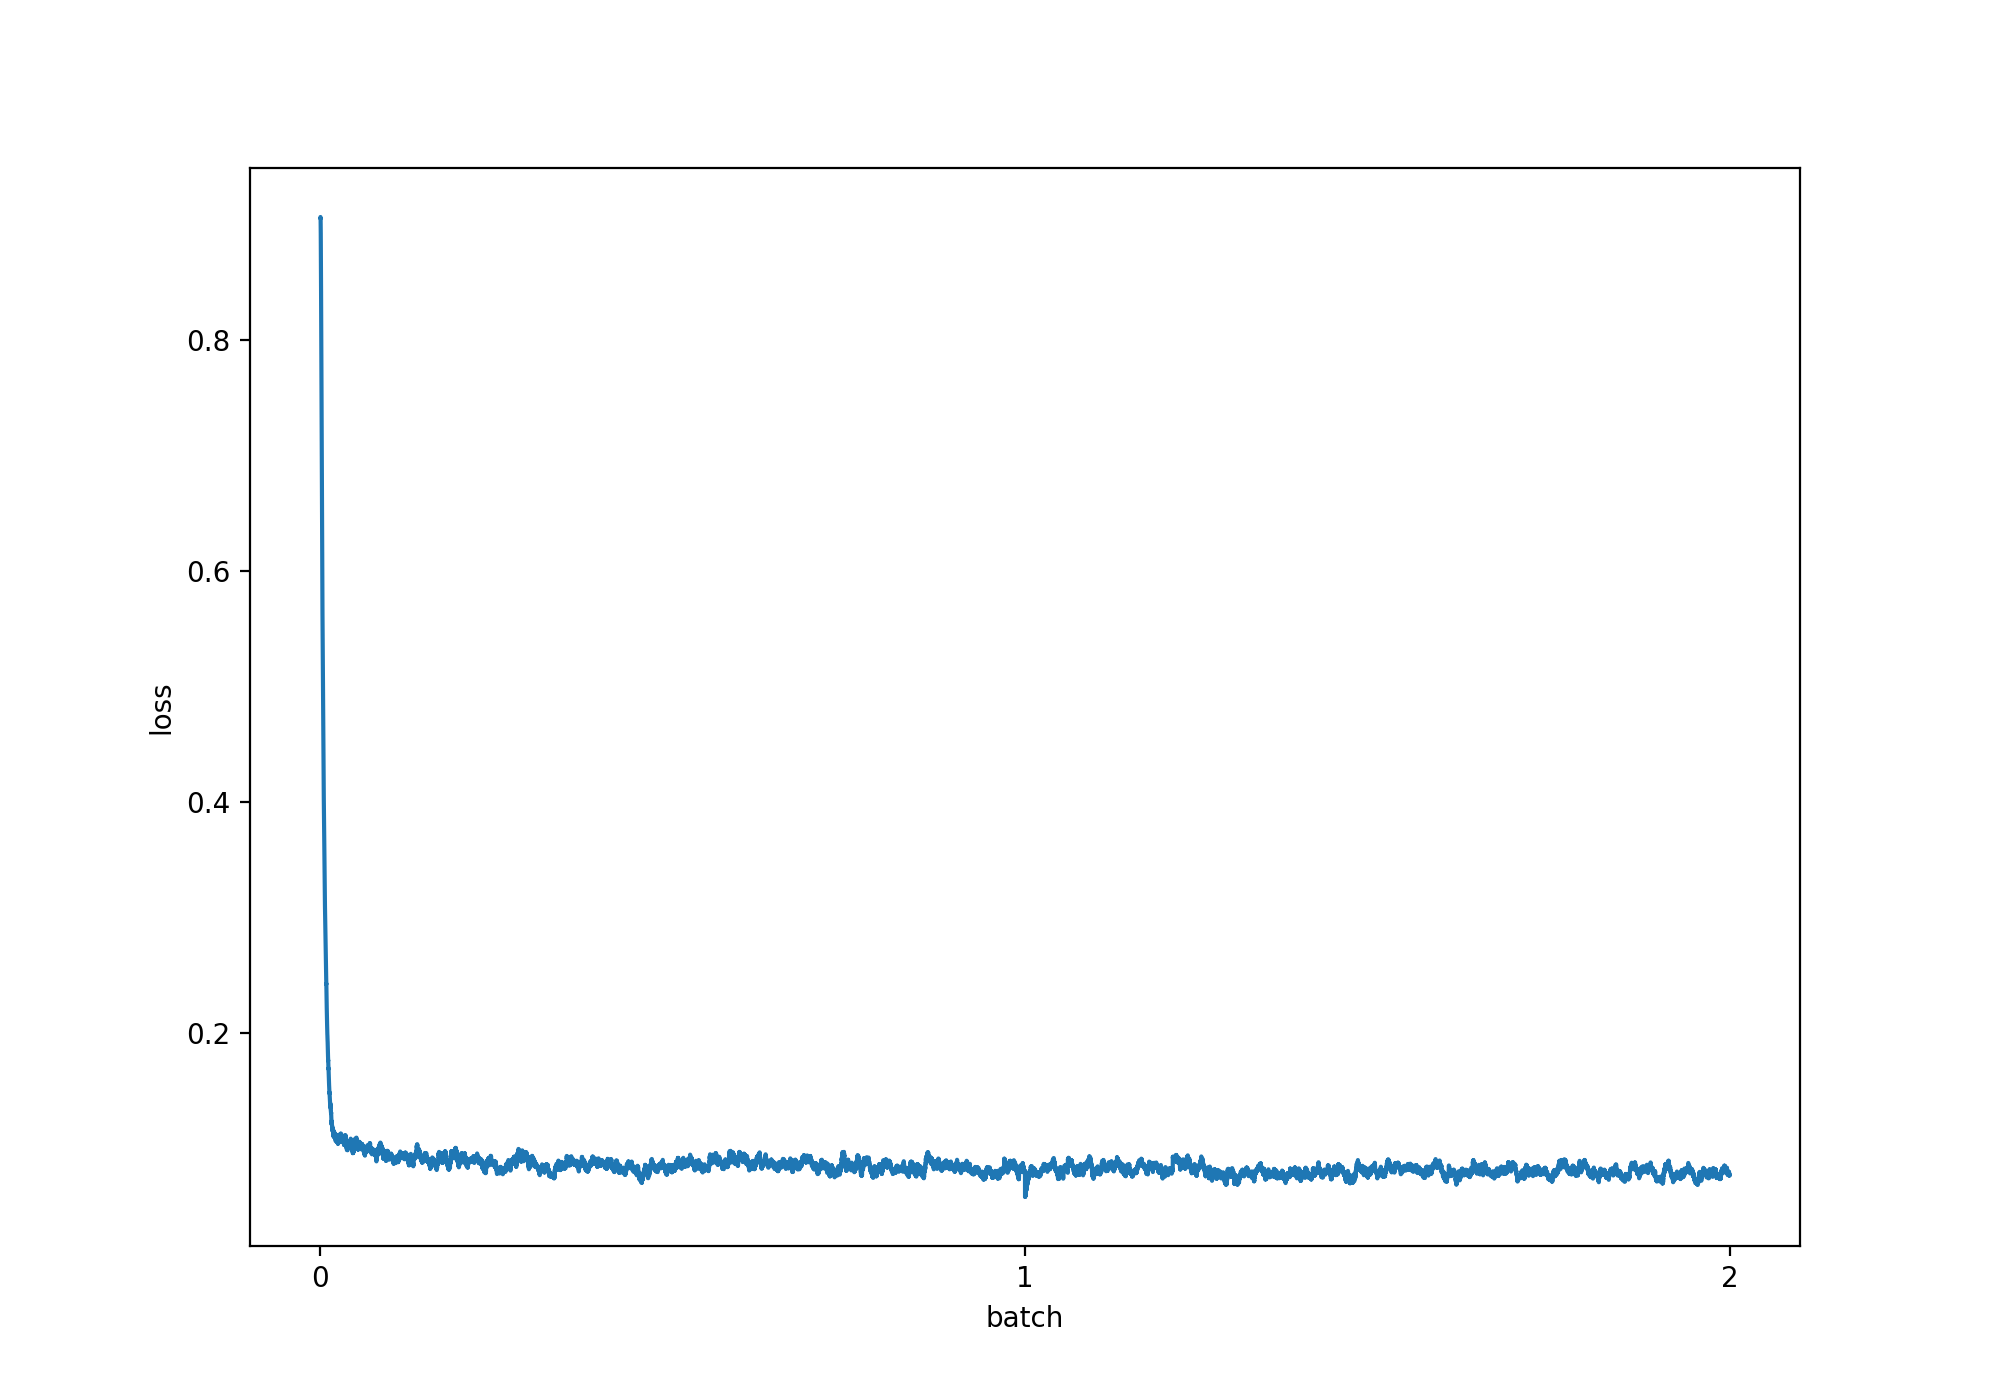

{'loss': 0.08063680332722578, 'val_loss': 0.07807432091188318}


{'loss': 0.07776801097896319, 'val_loss': 0.0766577373805448}

0.0766577373805448


In [12]:
%matplotlib nbagg

num_split=2
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=24
num_workers=12
num_epochs=2
model_name,version = 'Densenet161_3' , 'basic_classifier'
model1 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
model1.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model.features = model1.features
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,
                           window_eq=3,equalize=True)
transform_val=MyTransform(out_size=512)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,
                               window_eq=3,equalize=True)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,int(num_train_optimization_steps/num_epochs)+1)
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs*2,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)

torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [13]:
history

[{'loss': 0.08063680332722578, 'val_loss': 0.07807432091188318},
 {'loss': 0.07776801097896319, 'val_loss': 0.0766577373805448}]

In [17]:
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3,return_features=True)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model.to(device)
transform_val=MyTransform(out_size=512)
train_dataset=ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,
                          window_eq=3,equalize=True)
pred,features = model_run(model,train_dataset,do_apex=True,batch_size=96,num_workers=14)

pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'wb')
pickle.dump(features,pickle_file,protocol=4)
pickle_file.close()
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'predictions_train',num_split),'wb')
pickle.dump(preds,pickle_file,protocol=4)
pickle_file.close()

my_loss(pred[idx_validate],
        torch.tensor(train_df[hemorrhage_types].values[idx_validate],dtype=torch.float),
        torch.tensor([1.,1.,1.,1.,1.,2.]))

tensor(0.0767)

In [23]:
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'predictions_train',num_split),'wb')
pickle.dump(pred,pickle_file,protocol=4)
pickle_file.close()


/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedWriter name='/media/hd/notebooks/data/RSNA/outputs/model_Densenet161_3_vehrsion_basic_classifier_neighbors2_type_predictions_train_split_2.pkl'>
  """Entry point for launching an IPython kernel.


In [24]:
my_loss(pred,
        torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float),
        torch.tensor([1.,1.,1.,1.,1.,2.]))

tensor(0.0748)

In [15]:
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3,return_features=True)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model.to(device)
transform_val=MyTransform(out_size=512)
imagedataset_test=ImageDataset(test_df,transform=transform_val.random,base_path=test_images_dir,
                              window_eq=3,equalize=True)
pred,features = model_run(model,imagedataset_test,do_apex=True,batch_size=96,num_workers=18)
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'wb')
pickle.dump(features,pickle_file,protocol=4)
pickle_file.close()
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'predictions_test',num_split),'wb')
pickle.dump(pred,pickle_file,protocol=4)
pickle_file.close()

In [16]:
submission_df=get_submission(test_df,pred)
submission_df.head(12)
submission_df.shape
sub_num=18
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,0.027690
1,ID_000012eaf_epidural,0.000088
2,ID_000012eaf_intraparenchymal,0.007786
3,ID_000012eaf_intraventricular,0.001996
4,ID_000012eaf_subarachnoid,0.006615
5,ID_000012eaf_subdural,0.008678
6,ID_0000ca2f6_any,0.005620
7,ID_0000ca2f6_epidural,0.000010
8,ID_0000ca2f6_intraparenchymal,0.000846
9,ID_0000ca2f6_intraventricular,0.000098


(471270, 2)

<IPython.core.display.Javascript object>


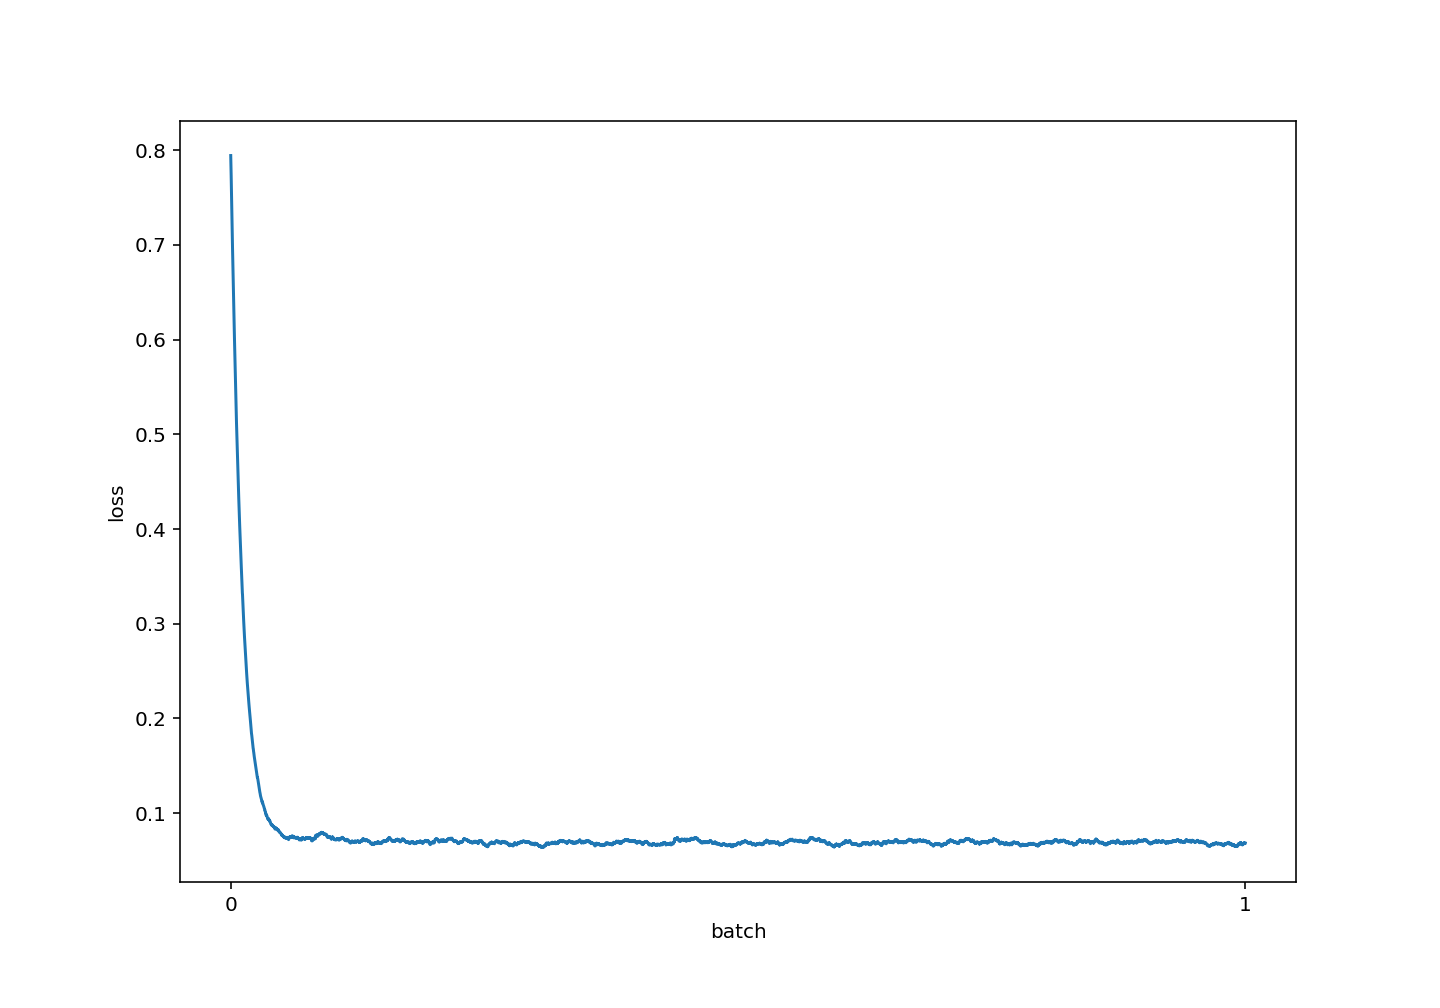

{'loss': 0.0684349455203913, 'val_loss': 0.06851208005827115}
0.06851208005827115


In [12]:
%matplotlib nbagg
num_neighbors=2
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128, 
                   dropout=0.5)


version=version+'_neighbors{}'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
features_dataset=FeatursDataset(train_df,features,num_neighbors,'SeriesI','ImagePositionZ',hemorrhage_types)
train_dataset=D.Subset(features_dataset,idx_train)
validate_dataset=D.Subset(features_dataset,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [13]:
num_neighbors=2
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),num_neighbors=num_neighbors,
                   classifier_layer=model0.classifier,intermidiate=128)
version=version+'_neighbors{}'.format(num_neighbors)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=FeatursDataset(test_df,features,num_neighbors,'SeriesI','ImagePositionZ')
pred = model_run(model,test_dataset,do_apex=False,batch_size=512)

In [14]:
submission_df=get_submission(test_df,pred)
submission_df.head(12)
submission_df.shape
sub_num=19
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,5.310079e-03
1,ID_000012eaf_epidural,1.698500e-05
2,ID_000012eaf_intraparenchymal,3.973674e-03
3,ID_000012eaf_intraventricular,9.255749e-05
4,ID_000012eaf_subarachnoid,1.262476e-03
5,ID_000012eaf_subdural,2.164259e-03
6,ID_0000ca2f6_any,1.198899e-03
7,ID_0000ca2f6_epidural,7.924000e-07
8,ID_0000ca2f6_intraparenchymal,2.181403e-03
9,ID_0000ca2f6_intraventricular,1.483470e-05


(471270, 2)

In [16]:
num_neighbors=2
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),num_neighbors=num_neighbors,
                   classifier_layer=model0.classifier,intermidiate=128)
version=version+'_neighbors{}'.format(num_neighbors)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=FeatursDataset(test_df,features,num_neighbors,'SeriesI','ImagePositionZ')
pred1 = model_run(model,test_dataset,do_apex=False,batch_size=512)

num_neighbors=2
model_name,version, num_split = 'Densenet161' , 'basic_more',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),num_neighbors=num_neighbors,
                   classifier_layer=model0.classifier,intermidiate=128)
version=version+'_neighbors{}'.format(num_neighbors)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=FeatursDataset(test_df,features,num_neighbors,'SeriesI','ImagePositionZ')
pred2 = model_run(model,test_dataset,do_apex=False,batch_size=512)

num_neighbors=2
model_name,version, num_split = 'Densenet161' , 'basic_more',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),num_neighbors=num_neighbors,
                   classifier_layer=model0.classifier,intermidiate=128)
version=version+'_neighbors{}in'.format(num_neighbors)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=FeatursDataset(test_df,features,num_neighbors,'SeriesI','ImagePositionZ')
pred3 = model_run(model,test_dataset,do_apex=False,batch_size=512)

In [17]:
pred=(pred1+(pred2+pred3)/2)/2

In [18]:
submission_df=get_submission(test_df,pred)
submission_df.head(12)
submission_df.shape
sub_num=20
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,2.244267e-03
1,ID_000012eaf_epidural,2.081427e-06
2,ID_000012eaf_intraparenchymal,5.646096e-04
3,ID_000012eaf_intraventricular,1.334408e-05
4,ID_000012eaf_subarachnoid,6.023869e-04
5,ID_000012eaf_subdural,6.491359e-04
6,ID_0000ca2f6_any,5.614207e-04
7,ID_0000ca2f6_epidural,1.539764e-07
8,ID_0000ca2f6_intraparenchymal,2.877309e-04
9,ID_0000ca2f6_intraventricular,1.732143e-06


(471270, 2)

<IPython.core.display.Javascript object>


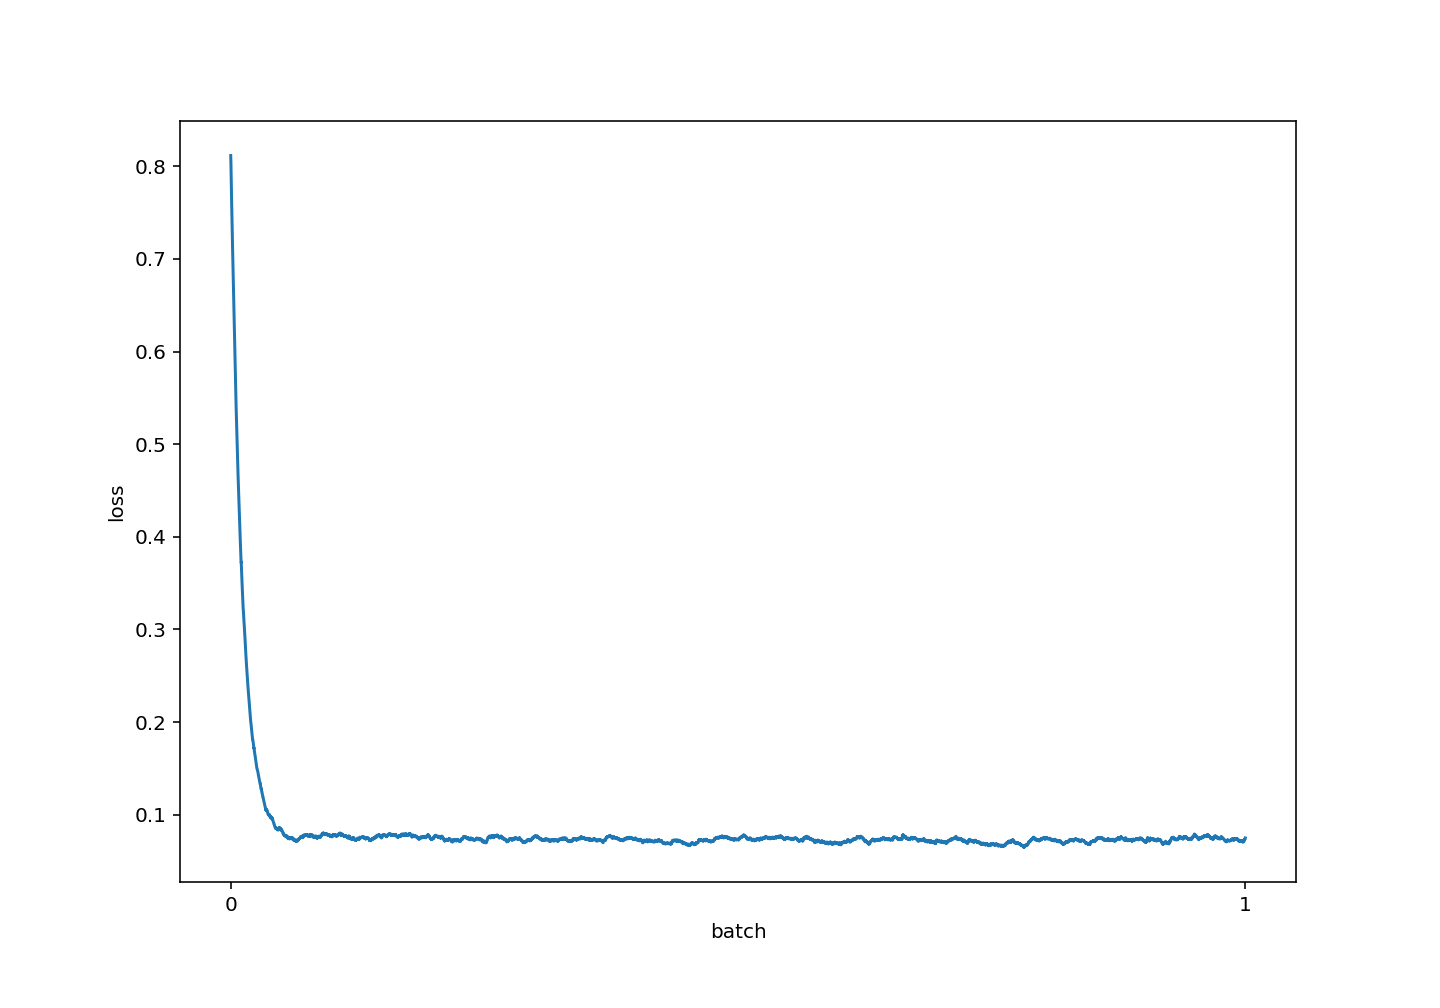

{'loss': 0.0749485937337074, 'val_loss': 0.07314836643778007}
0.07314836643778007


In [15]:
%matplotlib nbagg
num_neighbors=3
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128, 
                   dropout=0.5)


version=version+'_neighbors{}cor'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
features_dataset=FeatursDatasetCor(train_df,features,num_neighbors,'SeriesI',hemorrhage_types)
train_dataset=D.Subset(features_dataset,idx_train)
validate_dataset=D.Subset(features_dataset,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))